In [8]:
import numpy as np
from load import loadcfg
from collections import OrderedDict
import numpy as np
import control
import matplotlib.pyplot as plt
from numpy.linalg import linalg

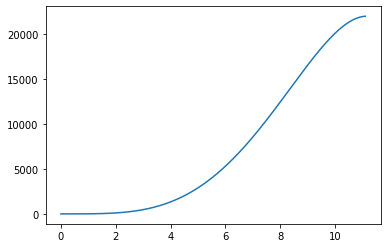

In [50]:
cfg = loadcfg("rocket.yaml")
p = cfg["properties"]
thrust = lambda a5, a4, a3, a2, a1, t:a5*(t**5) + a4*(t**4) + a3*t**3 +a2*t**2 +a1*t
acos = np.arccos
a =(-0.5,6.9, 1,1,1)
THRUST = lambda t: thrust(*a, t)
t = np.linspace(0,11.099,1000)
plt.plot(t, thrust(*a, t))

In [127]:
RotMat = lambda s, vx, vy, vz:\
    np.array([
        [1-2*vy**2-2*vz**2, 2*vx*vy-2*s*vz, 2*vx*vz-2*vy],
        [2*vx*vy+2*s*vz, 1-2*vx**2-2*vz**2, 2*vy*vz-2*s*vx],
        [2*vx*vz-2*s*vy, 2*vy*vz+2*s*vx, 1-2*vx**2-2*vy**2]
    ])

Q_ = lambda theta, A: \
    np.array([
        np.cos(theta/2), 
        np.sin(theta/2)*A[0],
        np.sin(theta/2)*A[1],
        np.sin(theta/2)*A[2]
    ])
YAW = lambda R: R @ np.transpose(p["YA0"])
PITCH = lambda R: R @ np.transpose(p["PA0"])
ROLL = lambda R: R @ np.transpose(p["RA0"])

XDOT = lambda P: P / p["Emass"]
OMEGA = lambda R, L: R @ np.linalg.inv(np.diag(p["I"])) @ R.T @ L.T
SDOT = lambda omega, v: 0.5*np.dot(omega, v)
VDOT = lambda s, omega, v: 0.5*(np.multiply(s, omega) + np.cross(omega, v))
QDOT = lambda s, omega, v: np.array([
    SDOT(omega, v),
    *VDOT(s, omega, v)
])
AOA = lambda v, R, roll: np.arccos(np.dot(v/np.linalg.norm(v)), roll)
def windspeed():
    return [0,0,0]

#apparent velocity
Vcm = lambda v: v + windspeed()
XBAR = np.abs(p["Xcp"] - p["Xcm"])
Vw = lambda roll, omega: XBAR * np.sin(np.dot(roll, omega*np.linalg.norm(omega)) * np.cross(roll, omega))
V = lambda v, roll, omega: Vcm(v) + Vw(roll, omega)

F_t = lambda t, roll: -THRUST(t)*roll
g = lambda z: p["Emass"] / (p["ER"] + z)**2
F_g = lambda z: np.array([0,0, -p["mass"]*g(z)]).T

F_A_MAG = lambda v: 0.5*p["rho"]*(np.linalg.norm(v)**2) *p["Arb"]*np.array(p["Ca"])
F_a = lambda v, roll: F_A_MAG(v) * roll
F_N_MAG = lambda v: 0.5*p["rho"]*(np.linalg.norm(v)**2)*p["Arb"]*np.array(p["Cn"])
F_n = lambda v, roll: F_N_MAG(v)*(np.cross(roll, np.cross(roll, np.divide(v,np.linalg.norm(v), where=np.linalg.norm(v)!=0))))
T_n = lambda roll, v:  XBAR* (np.cross(roll, np.cross(roll, np.divide(v,np.linalg.norm(v), where=np.linalg.norm(v)!=0))))
T_da = lambda R, omega: -np.linalg.norm(p["Cda"])*(R @ np.diag([1,1,0]) @ np.linalg.inv(R) @ omega)
T_R_MAG = lambda v: 0.5*p["rho"]*(np.linalg.norm(v)**2)*p["Arb"]*np.linalg.norm(np.array(p["Cr"])) * XBAR
T_r = lambda v, roll: T_R_MAG(v)*roll



In [131]:
def RocketModelDerivatives(t, X, Q, P, L):
    R = RotMat(*Q)
    xdot = XDOT(P)
    omega = OMEGA(R, L)
    qdot = QDOT(Q[0], omega, xdot)
    #aoa = AOA()
    yaw = YAW(R)
    pitch = PITCH(R)
    roll = ROLL(R)
    F = F_a(xdot, roll) + F_n(xdot, roll) + F_g(X[2]) + F_t(t, roll)
    T = T_n(roll, xdot) + T_da(R, omega) + T_r(xdot, roll)
    
    return np.array([xdot, qdot, F, T])

In [135]:
Q_i = Q_(np.pi/2.5, [1,1,1])
X_i = np.array([0,0,0])
P_i = X_i.copy()
L_i = P_i.copy()


In [136]:
RocketModelDerivatives(10, X_i, Q_i, P_i, L_i)

[array([0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([ 5.23007830e+03,  7.68133649e+03, -2.95559805e+19]),
 array([ 0., -0.,  0.])]

In [117]:
def RUNGEKUTTA5(t, f, inits, h=0.01):
    combine_list = lambda a, b: list(np.multipy(a,b))
    k1 = lambda t, h, states: [h*i for i in f(t, *states)]
    k2 = lambda t, h, states, k1: [h*i for i in f(t + 0.5*h, *com )]
    k3 = lambda t, h ,states: []



array([[-0.38196601, -0.26007351, -0.4845875 ],
       [ 1.64203952, -0.38196601, -0.26007351],
       [-0.26007351,  1.64203952, -0.38196601]])